In [ ]:
!pip install datasets
!pip install kaggle
!pip install segmentation-models-pytorch
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pkdarabi/brain-tumor-image-dataset-semantic-segmentation

In [102]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import seaborn as sns
import pandas as pd
import tensorflow as tf
import numpy as np
from zipfile import ZipFile
from PIL import Image
from sklearn.metrics import accuracy_score

In [103]:
BATCH_SIZE = 2
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
EPOCHS = 5
LEARNING_RATE = 3e-4

In [104]:
kaggle_json = {
    "username"  : "",
    "key"       : ""
}

with open('kaggle.json', 'w') as fp:
    json.dump(kaggle_json, fp)

In [105]:
path = '/content/brain-tumor-image-dataset-semantic-segmentation.zip'
with ZipFile(path, 'r') as zip:
  zip.extractall()

In [106]:
with open('/content/train/_annotations.coco.json','r') as file:
    train_data_json = json.load(file)

with open('/content/valid/_annotations.coco.json','r') as file:
    valid_data_json = json.load(file)

with open('/content/test/_annotations.coco.json','r') as file:
    test_data_json = json.load(file)

In [107]:
train_data = pd.merge(pd.DataFrame(train_data_json["images"]),
             pd.DataFrame(train_data_json["annotations"]), on="id")
train_data["file_name"] = train_data["file_name"].apply(lambda x: "train/" + x)

valid_data = pd.merge(pd.DataFrame(valid_data_json["images"]),
             pd.DataFrame(valid_data_json["annotations"]), on="id")
valid_data["file_name"] = valid_data["file_name"].apply(lambda x: "valid/" + x)

test_data = pd.merge(pd.DataFrame(test_data_json["images"]),
             pd.DataFrame(test_data_json["annotations"]), on="id")
test_data["file_name"] = test_data["file_name"].apply(lambda x: "test/" + x)

train_data.head()

,id,license,file_name,height,width,date_captured,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,1,train/2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928...,640,640,2023-08-19T04:37:54+00:00,0,1,"[145, 239, 168.75, 162.5]",27421.875,"[[313.75, 238.75, 145, 238.75, 145, 401.25, 31...",0
1,1,1,train/2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b...,640,640,2023-08-19T04:37:54+00:00,1,1,"[194, 176, 148.75, 233.75]",34770.313,"[[342.5, 176.25, 193.75, 176.25, 193.75, 410, ...",0
2,2,1,train/2921_jpg.rf.3b952f91f27a6248091e7601c223...,640,640,2023-08-19T04:37:54+00:00,2,1,"[133, 173, 162.5, 185]",30062.500,"[[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295,...",0
3,3,1,train/2777_jpg.rf.3b60ea7f7e70552e70e415280520...,640,640,2023-08-19T04:37:54+00:00,3,1,"[245, 358, 138.75, 166.25]",23067.188,"[[383.75, 357.5, 245, 357.5, 245, 523.75, 383....",0
4,4,1,train/2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec...,640,640,2023-08-19T04:37:54+00:00,4,1,"[80, 189, 112.5, 132.5]",14906.250,"[[192.5, 188.75, 80, 188.75, 80, 321.25, 192.5...",0


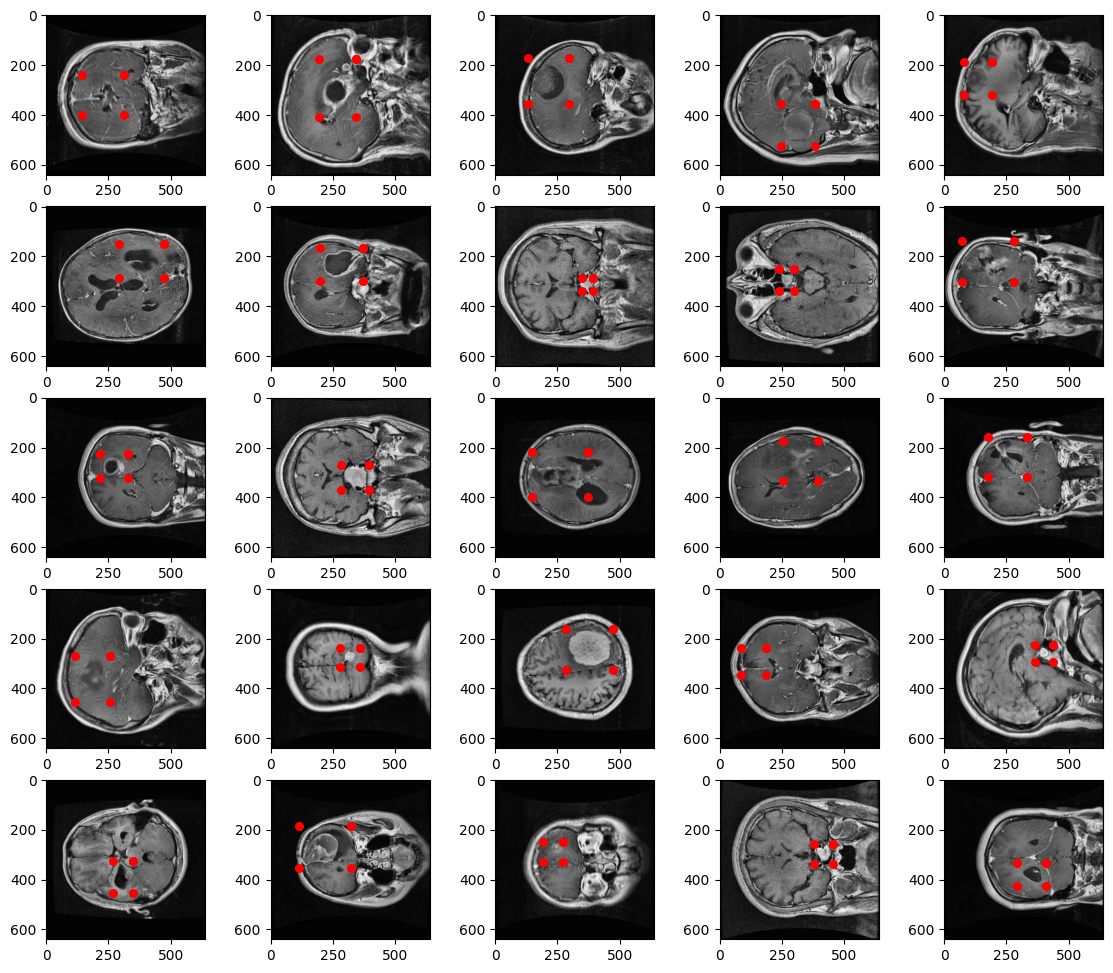

In [108]:
def plot_image(data, idx):
  img_name = data.iloc[idx]["file_name"]
  image = np.array(Image.open("/content/" + img_name))
  plt.imshow(image)

  points = np.array(data.iloc[idx]["segmentation"][0])
  points = points.reshape((-1, 1, 2)).squeeze(1)
  plt.scatter(points[:,0], points[:,1], color='red', s=30)


plt.figure(figsize=(14, 12))
for i in range(25):
  plt.subplot(5, 5, (i + 1))
  plot_image(train_data, i)

In [109]:
def create_masks(data, idx):
  temp = data.iloc[idx]
  points = torch.tensor(temp["segmentation"][0]).view((-1, 2))[:4]
  mat = torch.zeros((640, 640))

  mat[int(min(points[:,1]).item()):int(max(points[:,1]).item()),
      int(min(points[:,0]).item()):int(max(points[:,0]).item())] = 1

  return mat

In [110]:
arr = []
for data in [train_data, valid_data, test_data]:
  arr.append(torch.zeros((data.shape[0], 640, 640)))
  for i in range(data.shape[0]):
    mask = create_masks(data, i)
    arr[-1][i] = mask

train_masks, valid_masks, test_masks = arr

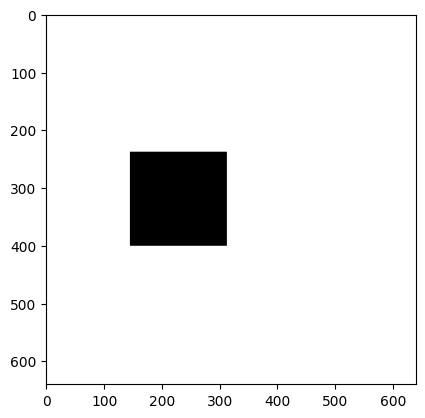

In [111]:
plt.imshow(train_masks[0], cmap='Greys')

In [112]:
class ImageDataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [113]:
train_img_paths = ["/content/" + train_data.iloc[i]["file_name"] for i in range(train_data.shape[0])]
valid_img_paths = ["/content/" + valid_data.iloc[i]["file_name"] for i in range(valid_data.shape[0])]
test_img_paths = ["/content/"  +  test_data.iloc[i]["file_name"] for i in range(test_data.shape[0])]

In [114]:
train_data = DataLoader(ImageDataset(train_img_paths, train_masks), BATCH_SIZE, shuffle=True)
valid_data = DataLoader(ImageDataset(valid_img_paths, valid_masks), BATCH_SIZE, shuffle=True)
test_data = DataLoader(ImageDataset(test_img_paths,   test_masks),  BATCH_SIZE, shuffle=True)

In [115]:
# using a pretrained one for now
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=1,
    classes=1,
    activation=None,
)

model.to(DEVICE)

optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [116]:
def convert_to_tensor(batch):
  batch_tensor = torch.zeros((len(batch), 640, 640, 3))
  for i in range(len(batch)):
    batch_tensor[i] = torch.tensor(np.array(Image.open(batch[i])))

  return batch_tensor

In [117]:
def train_epoch(model, train_data):
  model.train()
  lossi = []
  for x,y in train_data:
    y = y.unsqueeze(1).to(DEVICE)
    x = convert_to_tensor(x).to(DEVICE)
    x = x.view((BATCH_SIZE, 3, 640, 640))
    x = x.mean(dim=1, keepdim=True)
    output = model(x)

    loss = F.binary_cross_entropy_with_logits(output, y)
    optim.zero_grad()
    loss.backward()
    optim.step()

    lossi.append(loss.item())

  return torch.tensor(lossi).mean()

In [118]:
for epoch in range(EPOCHS):
  loss = train_epoch(model, train_data)
  print(f"EPOCH: {epoch}  |  LOSS: {loss}")

EPOCH: 0  |  LOSS: 0.16040222346782684
EPOCH: 1  |  LOSS: 0.1159859448671341
EPOCH: 2  |  LOSS: 0.11366593092679977
EPOCH: 3  |  LOSS: 0.1131444200873375
EPOCH: 4  |  LOSS: 0.11220133304595947


In [187]:
with torch.inference_mode():
  for x,y in train_data:
    y = y.unsqueeze(1).to(DEVICE)
    x = convert_to_tensor(x).to(DEVICE)
    x = x.view((BATCH_SIZE, 3, 640, 640))
    x = x.mean(dim=1, keepdim=True)
    output = model(x)
    if (F.sigmoid(output) > 0.5).sum().item() > 0:
      print(y[0].shape)
      print(F.binary_cross_entropy_with_logits(output[0], y[0]))
      break